<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/brace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/capstone/brace

/content/drive/MyDrive/Github/capstone/brace


In [3]:
%ls

 annotations/      dataset/             lstm_model2.pth         tensor_dataset.pkl
 bracedataset.py   dataset_pytorch.py   lstm_model.pth          test_subset.pkl
 brace_test.pkl    figures/            'MODELS ACCURACY.gdoc'   train_subset.pkl
 brace_test.pth    keras_model/         names                   utils/
 brace_train.pkl   k_model_features/    path/                   videos_info.csv
 brace_train.pth   k_model_features2/   __pycache__/
 dataClips         labels               README.md


In [4]:
# !nvidia-smi

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Github/capstone/brace')

In [6]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import bracedataset
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import TensorDataset
from tqdm import tqdm
from pathlib import PosixPath
import pickle
import re
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from torch.optim.lr_scheduler import ExponentialLR
import json
from pathlib import Path

In [37]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

from matplotlib import pyplot as plt
import seaborn as sns

Obtain BRACE dataset clips and labels, only need to to this once, they are saved for future reference


In [ ]:
# @title
# #load paths
# sequences_path = Path('/content/drive/MyDrive/Github/capstone/brace/dataset')
# pose_jsons = list(Path(sequences_path).rglob('**/*.json'))
# segments= pd.read_csv(Path('/content/drive/MyDrive/Github/capstone/brace/annotations/segments.csv'))
# #get clips
# dataClips, labels=bracedataset.BraceDataset(segments, pose_jsons)
# #encode labels from 0-2
# unique_categories = list(set(labels))
# category_to_int = {category: index for index, category in enumerate(unique_categories)}
# encoded_categories = [category_to_int[category] for category in labels]

# #get max length of the keypoints
# max_length = max(seq.shape[0] for seq in dataClips)

# #pad tensor so they are of the same lenght
# dataClips_tensors=[np.pad(array.astype(np.float32), ((0, max_length - array.shape[0]), (0, 0), (0, 0)), 'constant', constant_values=0) for array in dataClips]
# dataClips_tensors=torch.tensor(dataClips_tensors)
# #convert labels to tensors
# label_tensors = np.array(encoded_categories)
# label_tensors=torch.tensor(label_tensors)
# ##SPLIT SET FOR REPRODUCTIVITY
# dataset = TensorDataset(dataClips_tensors, label_tensors)
# # Set seed for reproducibility
# torch.manual_seed(42)

# # Determine split sizes
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size

# # Split dataset
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# print(f"Training set size: {len(train_dataset)}")
# print(f"Testing set size: {len(test_dataset)}")
# # Save the TensorDataset
# with open('tensor_dataset.pkl', 'wb') as f:
#     pickle.dump(dataset, f)

# # Save the Subset
# with open('train_subset.pkl', 'wb') as f:
#     pickle.dump(train_dataset, f)
# with open('test_subset.pkl', 'wb') as f:
#     pickle.dump(test_dataset, f)

In [ ]:
####### Categories {'toprock': 0, 'powermove': 1, 'footwork': 2}

Load previously saved dataset

In [2]:
# @title
# Load the TensorDataset
with open('tensor_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

# Load the training Subset
with open('train_subset.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

# Load the testing Subset
with open('test_subset.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'tensor_dataset.pkl'

In [ ]:
# @title
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Use this to load the dataset

In [ ]:
# @title
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes=3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# @title

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# @title
# Initialize the model
input_size = 17 * 2
hidden_size = 128
num_layers = 2
num_classes = 3

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10
for epoch in range(num_epochs):

    for sequences, labels in train_loader:
        sequences = sequences.to(device).view(-1, 1280, 34)  # Adjust shape for LSTM
        labels = labels.to(device)

        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# @title
# model_path = "lstm_model2.pth"
# torch.save(model.state_dict(), model_path)
# print(f"Model saved to {model_path}")

In [ ]:
# @title
# model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
# model.load_state_dict(torch.load(model_path))


# print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
# @title
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device).view(-1, 1280, 34)
        labels = labels.to(device)
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')
#accuracy 33.85%

CNN model with RNN layer


In [ ]:
# @title
# #load paths
# sequences_path = Path('/content/drive/MyDrive/Github/capstone/brace/dataset')
# pose_jsons = list(Path(sequences_path).rglob('**/*.json'))
# segments= pd.read_csv(Path('/content/drive/MyDrive/Github/capstone/brace/annotations/segments.csv'))
# #get clips
# dataClips, labels, names=bracedataset.BraceDataset(segments, pose_jsons)
# #encode labels from 0-2
# unique_categories = list(set(labels))
# category_to_int = {category: index for index, category in enumerate(unique_categories)}
# encoded_categories = [category_to_int[category] for category in labels]

# with open("dataClips", "wb") as fp:   #Pickling
#     pickle.dump(dataClips, fp)
# with open("labels", "wb") as fp:   #Pickling
#     pickle.dump(labels, fp)
# with open("names", "wb") as fp:   #Pickling
#     pickle.dump(names, fp)


In [8]:
# Load the TensorDataset
with open('dataClips', 'rb') as f:
    dataClips = pickle.load(f)

# Load the training Subset
with open('labels', 'rb') as f:
    labels = pickle.load(f)

# Load the testing Subset
with open('names', 'rb') as f:
    names = pickle.load(f)

#encode labels from 0-2
unique_categories = list(set(labels))
category_to_int = {category: index for index, category in enumerate(unique_categories)}
encoded_categories = [category_to_int[category] for category in labels]

In [9]:
flattened_clips = [clip.reshape(clip.shape[0], -1) for clip in dataClips]

padded_clips = pad_sequences(flattened_clips, padding='post', dtype='float32')


In [ ]:
#
### KERAS CNN MODEL######

X_train, X_test, y_train, y_test = train_test_split(
    padded_clips, encoded_categories, test_size=0.20, random_state=42)
# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Define the model
model = Sequential([
    LSTM(50, input_shape=(padded_clips.shape[1], padded_clips.shape[2])),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_split=0.2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                17000     
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 22403 (87.51 KB)
Trainable params: 22403 (87.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
27/27 [==============================] - 18s 536ms/step - loss: 1.0997 - accuracy: 0.3113 - val_loss: 1.0991 - val_accuracy: 0.2949
Epoch 2/1

In [ ]:
# @title
# model.save('/content/drive/MyDrive/Github/capstone/brace/keras_model')
# Load the model
loaded_model = load_model('path/to/location/keras_model')

# test
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test_onehot)
print(f'Test Accuracy: {test_accuracy}')

9/9 [==============================] - 2s 131ms/step - loss: 1.0955 - accuracy: 0.3616
Test Accuracy: 0.361623615026474


INCLUDE FEATURES IN THE MODEL

In [ ]:
# @title
#sort additional features
features= segments.copy()
features['uid']= pd.Categorical(features['uid'], categories=names, ordered=True)
features= features.sort_values(by='uid')
features['frames']= features['end_frame']- features['start_frame']


In [ ]:
# @title
# One-hot encode
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', OneHotEncoder(), ['seq_idx']),
        ('cat', OneHotEncoder(), ['dancer_id']),
        ('num', OneHotEncoder(), ['year']),

    ]
)

features_preprocessed = preprocessor.fit_transform(features[['seq_idx', 'dancer_id', 'year']])
features_preprocessed = features_preprocessed.toarray()
features_preprocessed[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [ ]:
# @title
# split train, test
X_train_clips, X_test_clips, X_train_features, X_test_features, y_train, y_test = train_test_split(
    padded_clips, features_preprocessed, encoded_categories, test_size=0.2, random_state=42)


y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

In [ ]:
# @title
# Keypoint input branch
keypoint_input = Input(shape=(X_train_clips.shape[1], X_train_clips.shape[2]), name='keypoint_input')
keypoint_model = LSTM(50)(keypoint_input)
keypoint_model = Dense(100, activation='relu')(keypoint_model)

# Additional features input branch
additional_features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
features_model = Dense(50, activation='relu')(additional_features_input)

# Concatenate the outputs of the two branches
combined = concatenate([keypoint_model, features_model])

# Add a classification layer
combined = Dense(100, activation='relu')(combined)
combined = Dropout(0.5)(combined)
output = Dense(3, activation='softmax')(combined)  # Assuming 3 classes

# Build the model
model = Model(inputs=[keypoint_input, additional_features_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check architecture
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 keypoint_input (InputLayer  [(None, 1280, 34)]           0         []                            
 )                                                                                                
                                                                                                  
 lstm (LSTM)                 (None, 50)                   17000     ['keypoint_input[0][0]']      
                                                                                                  
 features_input (InputLayer  [(None, 78)]                 0         []                            
 )                                                                                                
                                                                                              

In [ ]:
# @title
history = model.fit([X_train_clips, X_train_features], y_train_onehot, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
27/27 [==============================] - 18s 543ms/step - loss: 1.0998 - accuracy: 0.3414 - val_loss: 1.1071 - val_accuracy: 0.3041
Epoch 2/10
27/27 [==============================] - 10s 359ms/step - loss: 1.0954 - accuracy: 0.3519 - val_loss: 1.1055 - val_accuracy: 0.3318
Epoch 3/10
27/27 [==============================] - 11s 417ms/step - loss: 1.0825 - accuracy: 0.4155 - val_loss: 1.1165 - val_accuracy: 0.3226
Epoch 4/10
27/27 [==============================] - 12s 432ms/step - loss: 1.0833 - accuracy: 0.4120 - val_loss: 1.1128 - val_accuracy: 0.3088
Epoch 5/10
27/27 [==============================] - 12s 432ms/step - loss: 1.0713 - accuracy: 0.4306 - val_loss: 1.1167 - val_accuracy: 0.3134
Epoch 6/10
27/27 [==============================] - 11s 415ms/step - loss: 1.0555 - accuracy: 0.4630 - val_loss: 1.1219 - val_accuracy: 0.3134
Epoch 7/10
27/27 [==============================] - 10s 388ms/step - loss: 1.0554 - accuracy: 0.4606 - val_loss: 1.1293 - val_accuracy: 0.3226

In [ ]:
# @title
model.save('/content/drive/MyDrive/Github/capstone/brace/k_model_features')
# Load the model
loaded_model = load_model('/content/drive/MyDrive/Github/capstone/brace/k_model_features')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([X_test_clips, X_test_features], y_test_onehot)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}") #0.31

9/9 [==============================] - 1s 118ms/step - loss: 1.1632 - accuracy: 0.3247
Test Loss: 1.1632002592086792
Test Accuracy: 0.3247232437133789


CHANGE FEATURES TO SEQUENCE AND CLIP LENGHT, TO TEST IF THERE IS LESS OVERFITTING

In [ ]:
# @title
# One-hot encode
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', OneHotEncoder(), ['seq_idx']),
        ('frames', OneHotEncoder(), ['frames'])
    ]
)

features_preprocessed = preprocessor.fit_transform(features[['seq_idx', 'frames']])
features_preprocessed = features_preprocessed.toarray()
features_preprocessed.shape

(1352, 505)

In [ ]:
# @title
# #### KERAS FEATURE MODEL2#####

# X_train_clips, X_test_clips, X_train_features, X_test_features, y_train, y_test = train_test_split(
#     padded_clips, features_preprocessed, encoded_categories, test_size=0.2, random_state=42)


# y_train_onehot = to_categorical(y_train, num_classes=3)
# y_test_onehot = to_categorical(y_test, num_classes=3)

# # Keypoint input branch
# keypoint_input = Input(shape=(X_train_clips.shape[1], X_train_clips.shape[2]), name='keypoint_input')
# keypoint_model = LSTM(50)(keypoint_input)
# keypoint_model = Dense(100, activation='relu')(keypoint_model)

# # Additional features input branch
# additional_features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
# features_model = Dense(50, activation='relu')(additional_features_input)

# # Concatenate the outputs of the two branches
# combined = concatenate([keypoint_model, features_model])

# # Add a classification layer
# combined = Dense(100, activation='relu')(combined)
# combined = Dropout(0.5)(combined)
# output = Dense(3, activation='softmax')(combined)  # Assuming 3 classes

# # Build the model
# model = Model(inputs=[keypoint_input, additional_features_input], outputs=output)

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Model summary to check architecture
# model.summary()

In [ ]:
# @title

X_train_clips, X_test_clips, X_train_features, X_test_features, y_train, y_test = train_test_split(
    padded_clips, features_preprocessed, encoded_categories, test_size=0.2, random_state=42)


y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Keypoint input branch
keypoint_input = Input(shape=(X_train_clips.shape[1], X_train_clips.shape[2]), name='keypoint_input')
keypoint_model = LSTM(50, recurrent_regularizer=l1_l2(l1=0.01, l2=0.01))(keypoint_input)  # Adding regularization to LSTM
keypoint_model = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(keypoint_model)  # Adding regularization
keypoint_model = Dropout(0.5)(keypoint_model)  # Adding dropout

# Additional features input branch
additional_features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
features_model = Dense(50, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(additional_features_input)  # Adding regularization
features_model = Dropout(0.5)(features_model)  # Adding dropout

# Concatenate the outputs of the two branches
combined = concatenate([keypoint_model, features_model])

# Add a classification layer
combined = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(combined)  # Adding regularization
combined = Dropout(0.5)(combined)  # Adding dropout
output = Dense(3, activation='softmax')(combined)  # Assuming 3 classes

# Build the model
model = Model(inputs=[keypoint_input, additional_features_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check architecture
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 keypoint_input (InputLayer  [(None, 1280, 34)]           0         []                            
 )                                                                                                
                                                                                                  
 lstm_1 (LSTM)               (None, 50)                   17000     ['keypoint_input[0][0]']      
                                                                                                  
 features_input (InputLayer  [(None, 505)]                0         []                            
 )                                                                                                
                                                                                            

In [ ]:
# @title
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    [X_train_clips, X_train_features], y_train_onehot,
    validation_data=([X_test_clips, X_test_features], y_test_onehot),
    epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
34/34 [==============================] - 28s 714ms/step - loss: 30.7461 - accuracy: 0.3358 - val_loss: 22.2211 - val_accuracy: 0.3542
Epoch 2/100
34/34 [==============================] - 34s 1s/step - loss: 16.2763 - accuracy: 0.3525 - val_loss: 10.8972 - val_accuracy: 0.3616
Epoch 3/100
34/34 [==============================] - 20s 597ms/step - loss: 7.5851 - accuracy: 0.3228 - val_loss: 4.8566 - val_accuracy: 0.3616
Epoch 4/100
34/34 [==============================] - 24s 686ms/step - loss: 3.4924 - accuracy: 0.3321 - val_loss: 2.3563 - val_accuracy: 0.3616
Epoch 5/100
34/34 [==============================] - 29s 856ms/step - loss: 1.8171 - accuracy: 0.3191 - val_loss: 1.4518 - val_accuracy: 0.3616
Epoch 6/100
34/34 [==============================] - 29s 866ms/step - loss: 1.3050 - accuracy: 0.3599 - val_loss: 1.2047 - val_accuracy: 0.3616
Epoch 7/100
34/34 [==============================] - 25s 733ms/step - loss: 1.1854 - accuracy: 0.3377 - val_loss: 1.1714 - val_accuracy

In [ ]:

model.save('/content/drive/MyDrive/Github/capstone/brace/k_model_features3')
# Load the model
loaded_model = load_model('/content/drive/MyDrive/Github/capstone/brace/k_model_features3')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([X_test_clips, X_test_features], y_test_onehot)
print(f"Model name: {loaded_model}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 [==============================] - 1s 137ms/step - loss: 1.3042 - accuracy: 0.3321
Test Loss: 1.304213285446167
Test Accuracy: 0.33210331201553345


Try Dynamic Time Warping


In [ ]:
# @title
pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.1 MB/s eta 0:00:00


In [ ]:
# @title
from dtaidistance import dtw
from dtaidistance import dtw
from dtaidistance import clustering
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
# @title
dtw_means=[]
for i in dataClips:
    data=i
    data_flattened = [clip.reshape(clip.shape[0], -1) for clip in data]
    distance_matrix = dtw.distance_matrix_fast(data_flattened)
    mean_dist=distance_matrix.mean()
    dtw_means.append(mean_dist)

In [ ]:
# @title
len(dtw_means)


1352

Clustering with Dynamic Time Warping

In [ ]:
# @title
cluster_df=features[['seq_idx', 'frames']].copy()
cluster_df['dtw']= pd.Series(dtw_means)
cluster_df.shape

(1352, 3)

In [ ]:
# @title
scaler = StandardScaler()
clusters_scaled = scaler.fit_transform(cluster_df)
pca = PCA(n_components=2)
clusters_pca = pca.fit_transform(clusters_scaled)
pca_df = pd.DataFrame(data=clusters_pca, columns=['Principal Component 1', 'Principal Component 2'])

In [ ]:
# @title
kmeans = KMeans(n_clusters=3, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['Principal Component 1', 'Principal Component 2']])
pca_df['ActualLabels'] = encoded_categories

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


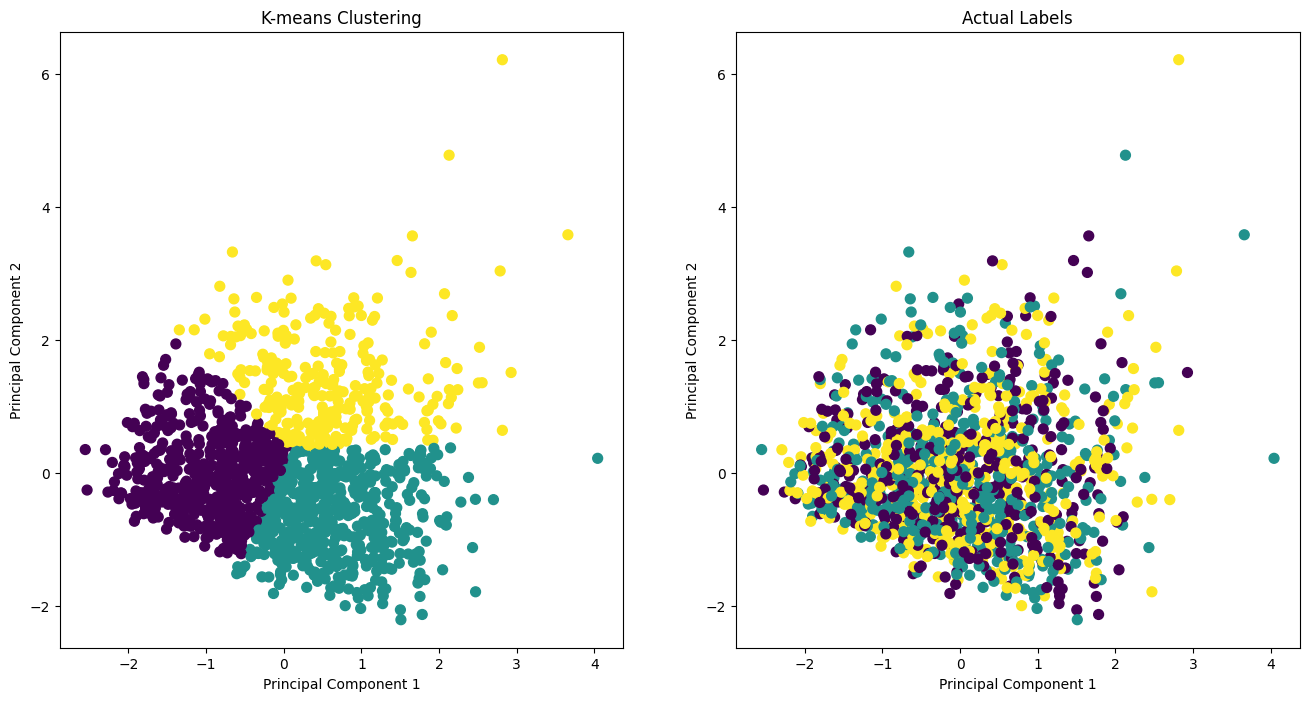

In [ ]:
# @title
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# K-means Cluster Plot
ax[0].scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['Cluster'], cmap='viridis', s=50)
ax[0].set_title('K-means Clustering')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')

# Actual Labels Plot
ax[1].scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['ActualLabels'], cmap='viridis', s=50)
ax[1].set_title('Actual Labels')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')

plt.show()

In [11]:
padded_clips.shape[1], 17, 2, 1

(1280, 17, 2, 1)

Time Distributed CNN

In [24]:
####### Time Distributed CNN
#train test set
X_train, X_test, y_train, y_test = train_test_split(
    padded_clips, encoded_categories, test_size=0.20, random_state=42)
# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

input_shape = (padded_clips.shape[1], 17, 2, 1)

model = Sequential([
    TimeDistributed(Conv1D(32, kernel_size=3, activation='relu'), input_shape=(1280, 34, 1)),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),

    LSTM(50),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')

])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, 1280, 32, 32)      128       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 1280, 16, 32)      0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 1280, 512)         0         
 istributed)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 50)                112600    
                                                                 
 dense_10 (Dense)            (None, 100)               5100      
                                                      

In [25]:
history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
27/27 [==============================] - 112s 4s/step - loss: 1.0994 - accuracy: 0.3380 - val_loss: 1.1016 - val_accuracy: 0.2949
Epoch 2/10
27/27 [==============================] - 119s 4s/step - loss: 1.0984 - accuracy: 0.3495 - val_loss: 1.1011 - val_accuracy: 0.2949
Epoch 3/10
27/27 [==============================] - 103s 4s/step - loss: 1.0980 - accuracy: 0.3484 - val_loss: 1.1029 - val_accuracy: 0.2949
Epoch 4/10
27/27 [==============================] - 99s 4s/step - loss: 1.0980 - accuracy: 0.3275 - val_loss: 1.1027 - val_accuracy: 0.2949
Epoch 5/10
27/27 [==============================] - 102s 4s/step - loss: 1.0968 - accuracy: 0.3495 - val_loss: 1.1038 - val_accuracy: 0.2949
Epoch 6/10
27/27 [==============================] - 108s 4s/step - loss: 1.0973 - accuracy: 0.3472 - val_loss: 1.1035 - val_accuracy: 0.2949
Epoch 7/10
27/27 [==============================] - 116s 4s/step - loss: 1.0979 - accuracy: 0.3472 - val_loss: 1.1025 - val_accuracy: 0.2949
Epoch 8/10
27/

In [29]:

model.save('/content/drive/MyDrive/Github/capstone/brace/timeDistModel')
# Load the model
loaded_model = load_model('/content/drive/MyDrive/Github/capstone/brace/timeDistModel')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([X_test], y_test_onehot)
print(f"Model name: {loaded_model}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 [==============================] - 11s 1s/step - loss: 1.0986 - accuracy: 0.3616
Model name: <keras.src.engine.sequential.Sequential object at 0x7e54783170d0>
Test Loss: 1.0985870361328125
Test Accuracy: 0.361623615026474


Analysis the angles of the hip-knee-ankle

In [30]:
#calculate angle of the hip, knee and elbow
def calculate_angle(p1, p2, p3):
    ba = p1 - p2
    bc = p3 - p2
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

#calculate angles
def calculate_leg_angles(sequence, keypoints):
    angles = []
    for pose in sequence:
        hip = pose[keypoints[0]]
        knee = pose[keypoints[1]]
        ankle = pose[keypoints[2]]
        angle = calculate_angle(hip, knee, ankle)
        angles.append(angle)
    return np.mean(angles)
#Extract and average angles for the right and left legs across sequences.
def extract_angles_from_dataset(data, labels, right_keypoints, left_keypoints):

    angles_right = []
    angles_left = []
    class_angles = {label: {'right': [], 'left': []} for label in np.unique(labels)}

    for sequence, label in zip(data, labels):
        angle_right = calculate_leg_angles(sequence, right_keypoints)
        angle_left = calculate_leg_angles(sequence, left_keypoints)
        class_angles[label]['right'].append(angle_right)
        class_angles[label]['left'].append(angle_left)

    return class_angles

In [31]:
# Keypoint indices for right and left legs
right_keypoints = [12, 14, 16]
left_keypoints = [11, 13, 15]

In [40]:
class_angles = extract_angles_from_dataset(flattened_clips, encoded_categories, right_keypoints, left_keypoints)
type(class_angles)

dict

In [39]:
encoded_categories[:5]

[2, 0, 0, 1, 2]

In [47]:
category_to_int= {'toprock': 0, 'powermove': 1, 'footwork': 2}

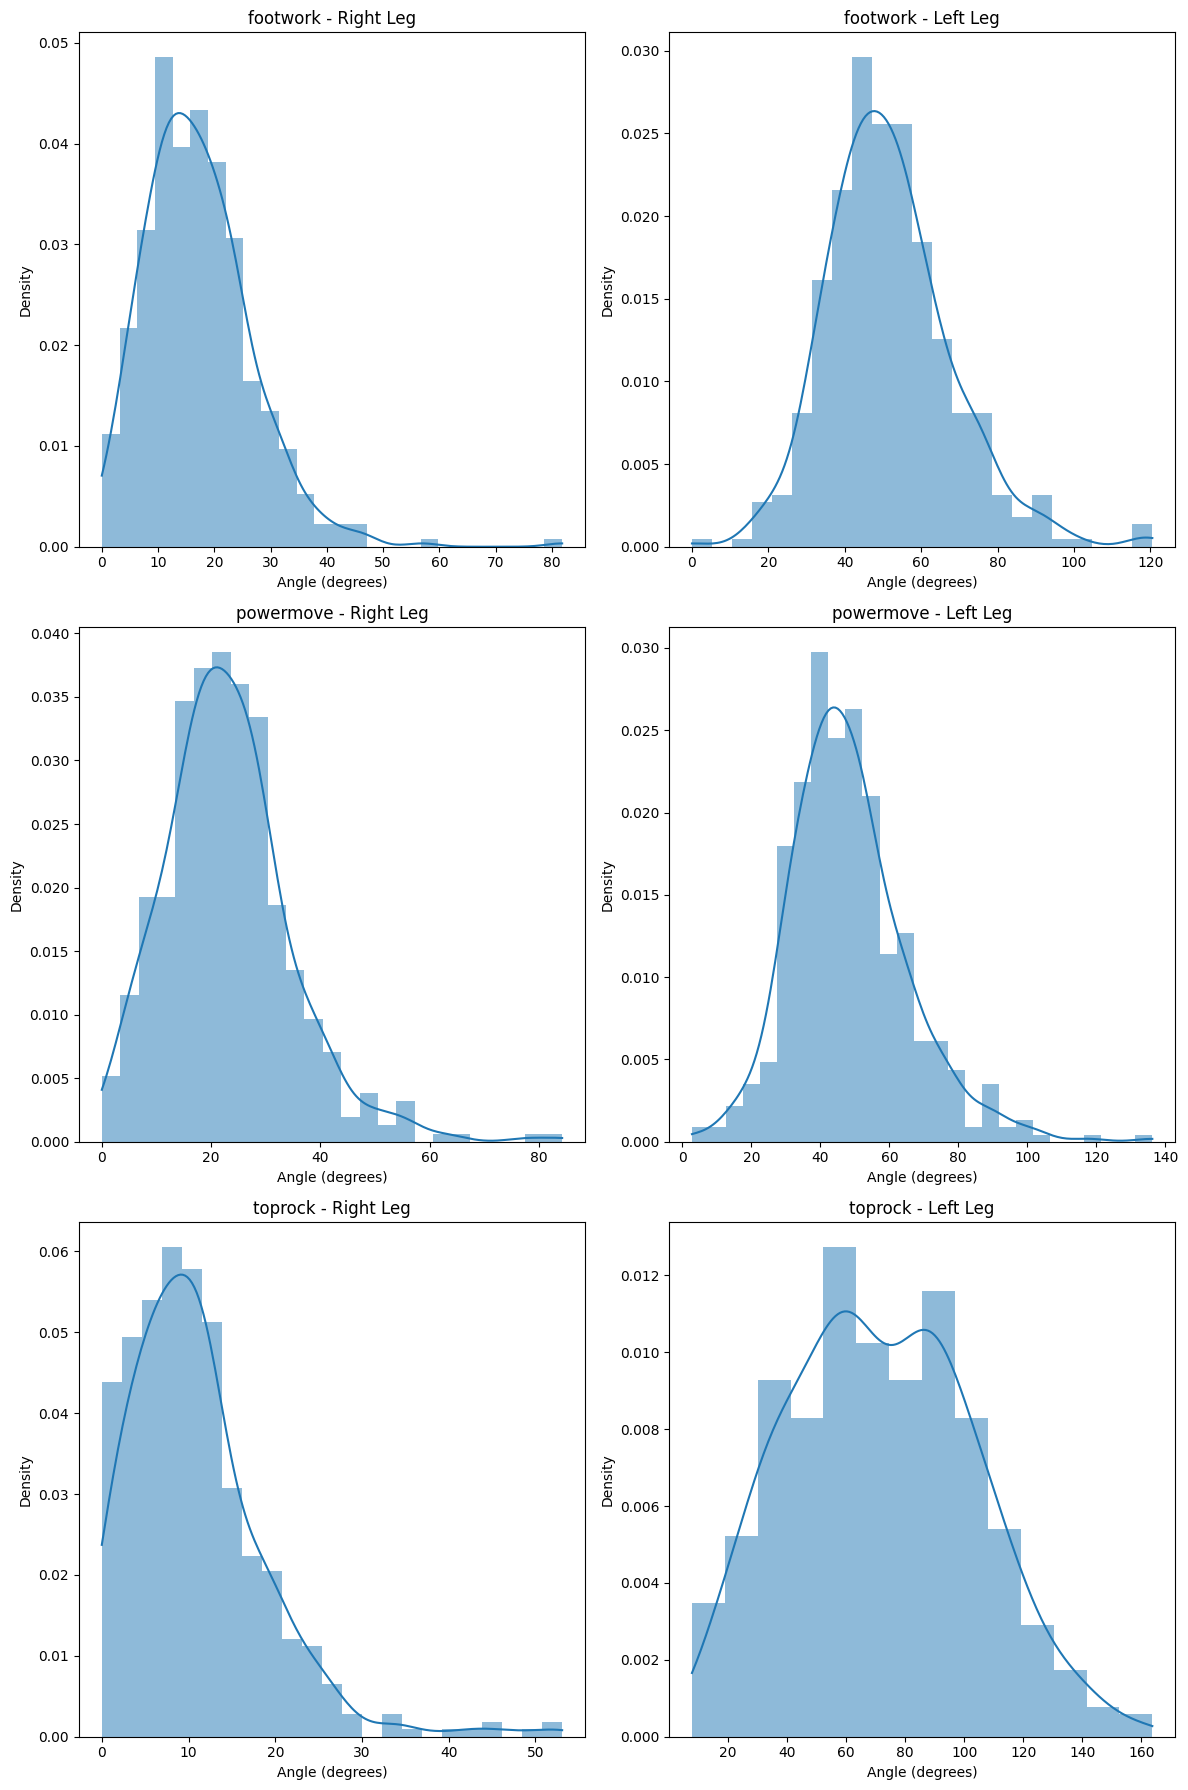

In [48]:
def plot_angle_distributions_3x2_with_category_names(class_angles, category_to_int):
    """Plot angle distributions in a 3x2 format, with category names for each class and leg side."""
    # Create a figure with 3 rows and 2 columns of subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    # Create a reverse mapping from integer labels to category names
    int_to_category = {v: k for k, v in category_to_int.items()}

    # Sort the class labels to ensure consistent plotting order
    sorted_labels = sorted(class_angles.keys(), key=lambda x: int_to_category[x])

    # Iterate through each class and plot right and left leg angles
    for i, label in enumerate(sorted_labels):
        category_name = int_to_category[label]  # Convert label to category name

        # Right leg plot for current class
        ax_right = axes[i*2]  # Even indices for right leg
        sns.histplot(class_angles[label]['right'], kde=True, ax=ax_right, stat="density", linewidth=0)
        ax_right.set_title(f'{category_name} - Right Leg')
        ax_right.set_xlabel('Angle (degrees)')
        ax_right.set_ylabel('Density')

        # Left leg plot for current class
        ax_left = axes[i*2 + 1]  # Odd indices for left leg
        sns.histplot(class_angles[label]['left'], kde=True, ax=ax_left, stat="density", linewidth=0)
        ax_left.set_title(f'{category_name} - Left Leg')
        ax_left.set_xlabel('Angle (degrees)')
        ax_left.set_ylabel('Density')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Assuming class_angles is already calculated and contains the angle data
# And assuming category_to_int is your category mapping dictionary
plot_angle_distributions_3x2_with_category_names(class_angles, category_to_int)

In [53]:
def calculate_mean_angles(class_angles):
    mean_angles = {}
    for label in class_angles:
        # Calculate mean angle for right leg
        mean_right = np.mean(class_angles[label]['right'])
        # Calculate mean angle for left leg
        mean_left = np.mean(class_angles[label]['left'])
        # Store the mean angles in the dictionary
        mean_angles[label] = {'right': mean_right, 'left': mean_left}
    return mean_angles

# Assuming class_angles is already calculated and contains the angle data
mean_angles = calculate_mean_angles(class_angles)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean Right Leg Angle: {mean_angles[label]['right']:.2f}, Mean Left Leg Angle: {mean_angles[label]['left']:.2f}")

Class toprock - Mean Right Leg Angle: 10.92, Mean Left Leg Angle: 71.66
Class powermove - Mean Right Leg Angle: 23.00, Mean Left Leg Angle: 48.30
Class footwork - Mean Right Leg Angle: 17.09, Mean Left Leg Angle: 51.52
